In [44]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import jax
from jax.experimental.ode import build_odeint
import jax.numpy as np
from jax.random import PRNGKey
from jax import lax

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

## Deterministic model

In [45]:
def dx_dt(x, t, beta, gamma):
    """
    SIR equations. Real positive parameters `beta`, `gamma`,
    describe the infection rate and recovery rate.
    Also tracks new infections.
    """
    S = x[0]
    I = x[1]
    R = x[2]
    n = S + I + R
    I_tot = x[3]
    dS_dt = - beta * S * I / n
    dI_dt = beta * S * I / n - gamma * I
    dR_dt = gamma * I
    dItot_dt = beta * S * I / n
    return np.stack([dS_dt, dI_dt, dR_dt, dItot_dt])

SIR_int = build_odeint(dx_dt, rtol=1e-5, atol=1e-3, mxstep=500)



## Current model: SIR model for new cases with random parameters/observations, deterministic dynamics

In [78]:
def SIR_hybrid(T = 50, 
               N = 1e5, 
               duration_mean = 10,
               R0_mean = 2.2,
               gamma_shape = 5,
               beta_shape = 5,
               det_rate_mean = 0.3,
               det_rate_conc = 100,
               det_conc = 100,
               confirmed = None):

    # Sample initial fraction of infected individuals
    I_init = numpyro.sample("I_init", dist.Uniform(0, 0.02))

    # Sample parameters
    gamma = numpyro.sample("gamma", 
                           dist.Gamma(gamma_shape, gamma_shape * duration_mean))
    
    beta = numpyro.sample("beta", 
                          dist.Gamma(beta_shape, beta_shape * duration_mean/R0_mean))

    det_rate = numpyro.sample("det_rate", 
                              dist.Beta(det_rate_mean * det_rate_conc,
                                        (1-det_rate_mean) * det_rate_conc))

    # Run simultation using ODE solve
    x_init = N * np.array([1-I_init, I_init, 0.0, I_init])
    t = np.arange(T, dtype='float32')
    x = SIR_int(x_init, t, beta, gamma)
    numpyro.deterministic("x", x)
    
    # Compute number of new infections in each time step
    latent = x[:,3]   # total number infected
    
    # Generate noisy observations as latent * Beta(alpha, beta)
    alpha = det_rate * det_conc * np.ones(T)
    beta = (1-det_rate) * det_conc * np.ones(T)

    d = dist.TransformedDistribution(dist.Beta(alpha, beta),
                                     dist.transforms.AffineTransform(0, scale=latent))

    rw = numpyro.sample("rw", dist.GaussianRandomWalk(1000,T))
    d_and_rw = dist.TransformedDistribution(d, dist.transforms.AffineTransform(rw,scale=0))
    mask = ~np.isnan(confirmed)
    with numpyro.handlers.mask(mask):
        y = numpyro.sample("y", d_and_rw, obs = confirmed)
    return x, y, det_rate

In [79]:
with numpyro.handlers.seed(rng_seed=1):
    x, y, det_rate = SIR_hybrid(T=100, N=1e6)
    #plt.plot(x[:,1])
    plt.plot(y)
    plt.show()

TypeError: No abstraction handler for type: <class 'NoneType'>

In [48]:
def plot_samples(samples, plot_fields=['I', 'y'], T=None, t=None, ax=None):
    
    T_data = samples['x'].shape[1] - 1
    if T is None or T > T_data:
        T = T_data

    X = samples['x']
    
    labels = {
        'S': 'susceptible',
        'I': 'infected',
        'R': 'removed',
        'C': 'confirmed'
    }
    
    fields = {'S': X[:,:T,0],
              'I': X[:,:T,1],
              'R': X[:,:T,2],
              'C': X[:,:T,3]}    
    
    if 'y' in samples:
        fields['y'] = samples['y'][:,:T]
    
    fields = {k: fields[k] for k in plot_fields}

    means = {k: v.mean(axis=0) for k, v in fields.items()}
    
    pred_intervals = {k: np.percentile(v, (10, 90), axis=0) for k, v in fields.items()}
    
    # Use pandas to plot means (for better date handling)
    if t is None:
        t = np.arange(T)        

    df = pd.DataFrame(index=t, data=means)
    df.plot(ax=ax)
    
    # Add prediction intervals
    for k, pred_interval in pred_intervals.items():
        ax = ax if ax is not None else plt.gca()
        ax.fill_between(t, pred_interval[0,:], pred_interval[1,:], alpha=0.1)

In [75]:
import jhu

US = jhu.load_us()

pop = {
    'tot': 3.27e8,
    'MA': 6.902e6,
    'WA': 7.536e6,
    'NY': 8.632e6
}

place = 'NY'

start = pd.Timestamp('2020-03-02')

confirmed = US[place].confirmed[start:]
confirmed_data = confirmed.to_numpy()
print (confirmed_data)
T = len(confirmed_data)
N = pop[place]

kernel = NUTS(SIR_hybrid)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=1)

init = {
    'I_init': 0.01,
    'gamma': 1/10.0,
    'beta': 2.5/10.0,
    'det_rate' : 0.3,
    'rw' : 100000 * np.ones(T)
}

mcmc.run(jax.random.PRNGKey(2), N=N, T=T, confirmed=confirmed_data, det_conc=5, init_params=init)
mcmc.print_summary()
mcmc_samples = mcmc.get_samples()


[    1     2    11    23    31    76   106   142   173   220   328   421
   525   732   967  1706  2495  5365  8310 11710 15793]


sample: 100%|██████████| 6000/6000 [01:51<00:00, 53.92it/s, 1 steps of size 1.18e-38. acc. prob=0.00] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    I_init      0.01      0.00      0.01      0.01      0.01       nan       nan
      beta      1.28      0.00      1.28      1.28      1.28       nan       nan
  det_rate      0.57      0.00      0.57      0.57      0.57      0.50      1.00
     gamma      1.11      0.00      1.11      1.11      1.11      0.50      1.00
     rw[0] 100000.00      0.00 100000.00 100000.00 100000.00       nan       nan
     rw[1] 100000.00      0.00 100000.00 100000.00 100000.00       nan       nan
     rw[2] 100000.00      0.00 100000.00 100000.00 100000.00       nan       nan
     rw[3] 100000.00      0.00 100000.00 100000.00 100000.00       nan       nan
     rw[4] 100000.00      0.00 100000.00 100000.00 100000.00       nan       nan
     rw[5] 100000.00      0.00 100000.00 100000.00 100000.00       nan       nan
     rw[6] 100000.00      0.00 100000.00 100000.00 100000.00       nan       nan
     rw[7] 100000.00      0

In [63]:
# Visualize posterior predictive samples
T = 200
post_pred = Predictive(SIR_hybrid, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T=T, N=N)
np.mean(mcmc_samples['beta'] - mcmc_samples['gamma'])




TypeError: add got incompatible shapes for broadcasting: (21,), (200,).

NameError: name 'post_pred_samples' is not defined

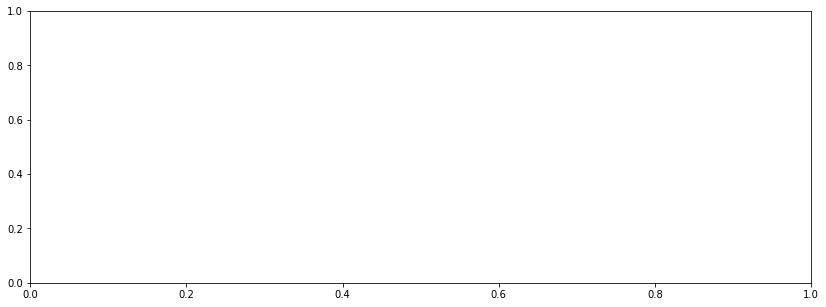

In [52]:
scale = 'notlog'

for T in [25,6*7,30*3]:
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    fig, ax = plt.subplots(figsize=(14,5))
    plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'])
    plt.title('Posterior predictive')
    
    confirmed.plot(style='o')
    
    if scale == 'log':
        plt.yscale('log')
        
    #filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.pdf'
    #plt.savefig(filename)
    plt.show()
    